In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [20]:
target = 'num_orders'

features = ['center_id', 'meal_id', 'checkout_price', 'mean_base_price', 'discount', 'emailer_for_promotion', 
            'homepage_featured', 'city_code', 'center_type', 'category', 'year', 'region_code', 'month', 
            'week_in_month', 'cuisine', 'avg_orders_26week_adj', 'avg_orders_52week', 
            'avg_orders_26week', 'avg_orders_26week_adj_across', 'avg_orders_26week_across']

categorical_columns = ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 
                       'city_code', 'region_code', 'center_type', 'category', 'cuisine', 'year', 'month', 'quarter', 
                       'week_in_month']

encoded_columns = ['center_id_55', 'meal_id_1885', 'emailer_for_promotion_0', 'homepage_featured_0', 'city_code_647', 
                   'region_code_56', 'center_type_TYPE_C', 'category_Beverages', 'cuisine_Italian', 'year_3', 
                   'month_1', 'week_in_month_2']

def evaluate(y_test, y_pred):
    return 100 * np.sqrt(mean_squared_error(y_test, y_pred))

In [21]:
trainset = pd.read_csv("train_feature.csv", index_col='id').fillna(0)
trainset.head()

,num_orders,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,avg_orders_13week_across,avg_orders_26week_across,avg_orders_52week_across,avg_orders_13week_adj_across,avg_orders_26week_adj_across,discount,year,month,quarter,week_in_month
id,,,,,,,,,,,,,,,,,,,,,
1379560,177,1,55,1885,136.83,152.29,0,0,647,56,...,726.506494,726.506494,726.506494,0.0,0.0,0.101517,1,1,1,1
1466964,270,1,55,1993,136.83,135.83,0,0,647,56,...,793.896104,793.896104,793.896104,0.0,0.0,-0.007362,1,1,1,1
1346989,189,1,55,2539,134.86,135.86,0,0,647,56,...,272.116883,272.116883,272.116883,0.0,0.0,0.007361,1,1,1,1
1338232,54,1,55,2139,339.50,437.53,0,0,647,56,...,49.709677,49.709677,49.709677,0.0,0.0,0.224053,1,1,1,1
1448490,40,1,55,2631,243.50,242.50,0,0,647,56,...,74.014085,74.014085,74.014085,0.0,0.0,-0.004124,1,1,1,1


In [22]:
trainset.cuisine.value_counts()

Italian        122925
Thai           118216
Indian         112612
Continental    102795
Name: cuisine, dtype: int64

In [23]:
testset = pd.read_csv("test_feature.csv", index_col='id').fillna(0)
testset.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,...,avg_orders_13week_across,avg_orders_26week_across,avg_orders_52week_across,avg_orders_13week_adj_across,avg_orders_26week_adj_across,discount,year,month,quarter,week_in_month
id,,,,,,,,,,,,,,,,,,,,,
1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,...,718.100000,719.609915,750.125657,718.923721,711.837838,-0.083689,3,11,4,2
1127204,146,55,1993,160.11,159.11,0,0,647,56,TYPE_C,...,486.656344,493.422289,528.837337,485.195915,507.465476,-0.097471,3,11,4,2
1212707,146,55,2539,157.14,159.14,0,0,647,56,TYPE_C,...,222.087613,226.483723,264.149211,223.408144,226.485104,-0.074594,3,11,4,2
1082698,146,55,2631,162.02,162.02,0,0,647,56,TYPE_C,...,137.327331,116.760939,106.818255,112.733799,110.001028,0.046584,3,11,4,2
1400926,146,55,1248,163.93,163.93,0,0,647,56,TYPE_C,...,96.961538,84.167702,72.140451,81.720856,76.970362,0.042897,3,11,4,2


In [24]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 1028232 to 1291286
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   week                          32573 non-null  int64  
 1   center_id                     32573 non-null  int64  
 2   meal_id                       32573 non-null  int64  
 3   checkout_price                32573 non-null  float64
 4   base_price                    32573 non-null  float64
 5   emailer_for_promotion         32573 non-null  int64  
 6   homepage_featured             32573 non-null  int64  
 7   city_code                     32573 non-null  int64  
 8   region_code                   32573 non-null  int64  
 9   center_type                   32573 non-null  object 
 10  op_area                       32573 non-null  float64
 11  category                      32573 non-null  object 
 12  cuisine                       32573 non-null  object

In [25]:
def preprocess(trainset, testset, remove_outliers=False):
    
    if remove_outliers:
        trainset = trainset[trainset.num_orders <= 20000]
        trainset = trainset[trainset.checkout_price >= 3]
        
    dataset = trainset.append(testset, sort=False).fillna(0)
    
    for column in categorical_columns:
        dataset[column] = dataset[column].astype('category')
    
    dataset = dataset[features]
    
    dataset = pd.get_dummies(dataset[features])
    dataset = dataset.drop(encoded_columns, axis=1)
    
    trainset = trainset[[target]].join(dataset)
    testset = testset[[]].join(dataset)
    
    return trainset, testset

In [26]:
trainset, testset = preprocess(trainset, testset)

print("Trainset size: {}".format(trainset.shape))
print("Testset size: {}".format(testset.shape))

Trainset size: (456548, 229)
Testset size: (32573, 228)


In [27]:
feature_columns = trainset.columns
feature_columns = feature_columns[feature_columns != target]
feature_columns.shape

# feature_columns = features

(228,)

In [30]:
trainset, validationset = train_test_split(trainset, random_state=41, test_size=0.2)

X_train, y_train = trainset[feature_columns], np.log(trainset[target])
X_val, y_val = validationset[feature_columns], np.log(validationset[target])

print("Train set size: {}".format(X_train.shape))
print("Validation set size: {}".format(X_val.shape))

Train set size: (365238, 228)
Validation set size: (91310, 228)


Filtering of features was done using the out-of-box LightGBM model. Since, it is
faster to train and can handle categorical features easily.


In [31]:
lgb = LGBMRegressor(importance_type='gain')
params = {
    'num_leaves': [41, 51],
    'n_estimators': [230, 260],
    'min_child_samples': [40, 45, 50],
    'random_state': [2019]
}
lgb_grid = GridSearchCV(lgb, params, cv=5, scoring='neg_mean_squared_error', n_jobs=8)
lgb_grid.fit(X_train, y_train)
lgb = lgb_grid.best_estimator_

score = evaluate(y_val, lgb.predict(X_val))
print('Best Estimator: {}'.format(lgb))
print('Best Score on validation: {}'.format(score))

Best Estimator: LGBMRegressor(importance_type='gain', min_child_samples=45, n_estimators=260,
              num_leaves=51, random_state=2019)
Best Score on validation: 44.696029879469734


The __evaluation
metric of 100 * RMSLE__ final model is getting the score of __44.2260.__

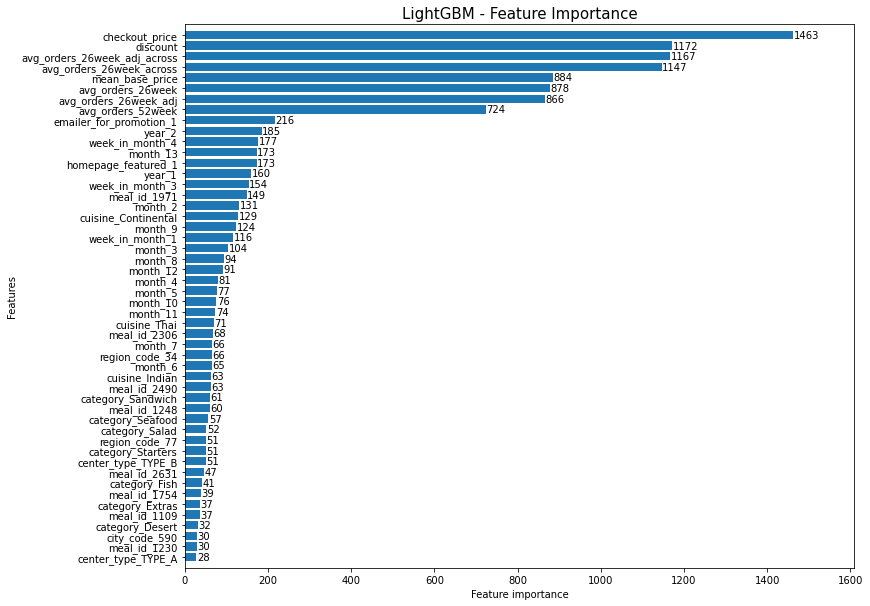

In [32]:
ax = plot_importance(lgb_grid.best_estimator_, max_num_features=50, height=0.8, figsize=(12, 10))
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [33]:
%%time
xgb = XGBRegressor(objective='reg:squarederror', random_state=41,missing=0.0, n_jobs=8, 
                   max_depth=9, n_estimators=300, min_child_weight=45)
xgb.fit(X_train, y_train)
evaluate(y_val, xgb.predict(X_val))

Wall time: 3min 30s


43.116280102275674

In [35]:
X_test = testset[feature_columns]
y_pred = (np.exp(lgb.predict(X_test)) + np.exp(xgb.predict(X_test))) / 2
testset[target] = np.round(y_pred, decimals=0)

submission = testset[[target]]
submission.to_csv('final.csv')

Since, both the models are performing nearly the same on test set. Average of outcomes from both the models was also evaluated on test set. It gave the result of 44.00